# Import and Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
sys.path.append('/g/g99/jamil1/lustre1/sensitivity/modules')

Import useful libraries for analysis

In [3]:
import os
import pandas as pd
import histlite as hl
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
params = {'font.size':16,'font.family':'serif'}
plt.rcParams.update(params) 


plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (10,8)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['blue', 'red', 'green', 'orange', 'violet','magenta']

Import the nEXO sensitivity classes

In [4]:
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

Useful functions

In [5]:
from decimal import Decimal

def ProgressBar(count, total, phrase):
    barLength = 15 # Modify this to change the length of the progress bar
    status = '%d/%d' % (count+1, total)
    progress = (count+1)/float(total)
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if count == total-1:
        progress = 1
        status = status+"           \n"
    block = int(round(barLength*progress))
    text = '\r%-*s [%s] %-*s %s' % (47,phrase,"#"*block+"-"*(barLength-block),8,'%.2f%%'%Decimal(progress*100),status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [6]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [7]:
mmass_xe136 = 135.907214 # in gram/mol 
mmass_xe134 = 133.905393 # in gram/mol 
Avogadro = 6.02214076E23 # in 1/mol
bb0n_eff = 0.963
XeMass_fiducial = 3281.0*1000.0 # in gram
frac_136 = 0.9
frac_134 = 0.1

def GetLivetime(Num, Livetime):
    NXenon136 = (XeMass_fiducial * Avogadro * frac_136) / (frac_136 * mmass_xe136 + frac_134  * mmass_xe134)
    return bb0n_eff * NXenon136 * Livetime  * np.log(2.0) / Num

# Data Read-In

In [8]:
OutputDir = '/g/g99/jamil1/lustre1/sensitivity/work/SensitivityPaper2020_scripts/DiscoveryPotential/Data/version4/h5/'

AllFiles = os.listdir(OutputDir)
H5Files = [filename for filename in AllFiles if filename.endswith('.h5')]
print('Number of files {}'.format(len(H5Files)))

Number of files 1300


In [9]:
Livetimes = [1.0,5.0,10.0]
Livetimes = [10.0]

Tags = {}
for Livetime in Livetimes: 
    Tags[Livetime] = natural_sort(np.unique(['_'.join(x.split('_')[:3])+'_%.1fyrs' % Livetime for x in H5Files if '%.1fyrs' % Livetime in x]))
    print(Tags[Livetime])

['DiscoveryPotential_bb0n_0ct_10.0yrs', 'DiscoveryPotential_bb0n_10ct_10.0yrs', 'DiscoveryPotential_bb0n_15ct_10.0yrs', 'DiscoveryPotential_bb0n_18ct_10.0yrs', 'DiscoveryPotential_bb0n_20ct_10.0yrs']


In [10]:
dfdict = {}

for Livetime in Livetimes: 
    dfdict[Livetime] = {}
    for category in Tags[Livetime]:
        print('Loading data for {}'.format(category))
        df_list = [pd.read_hdf(OutputDir+filename) for filename in H5Files if category in filename]
        dfdict[Livetime][category] = pd.concat(df_list,ignore_index=True)
        print('Number of file for {}: {}'.format(category, len(df_list)))

Loading data for DiscoveryPotential_bb0n_0ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_0ct_10.0yrs: 900
Loading data for DiscoveryPotential_bb0n_10ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_10ct_10.0yrs: 100
Loading data for DiscoveryPotential_bb0n_15ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_15ct_10.0yrs: 100
Loading data for DiscoveryPotential_bb0n_18ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_18ct_10.0yrs: 100
Loading data for DiscoveryPotential_bb0n_20ct_10.0yrs
Number of file for DiscoveryPotential_bb0n_20ct_10.0yrs: 100


# Selection Cut
Prevent datasets from entering the distribution of test statistics for which either one of the hypothesis test fits with a fixed number of bb0n counts or the global best fit did not converge

In [11]:
maskdict = {}

for Livetime in Livetimes: 
    maskdict[Livetime] = {} 
    for key, df in dfdict[Livetime].items():
        print('Running {}'.format(key))
        good_fit_mask = []
        counts = 0
        for index,row in df.iterrows():
            if np.sum(row['fixed_fit_acc_covar']) < len(row['fixed_fit_acc_covar'])-1 or not row['best_fit_covar'] or not row['best_fit_converged'] :
                counts += 1
                good_fit_mask.append(False)
            else:
                good_fit_mask.append(True)

        maskdict[Livetime][key] = np.array(good_fit_mask)
        print("%.2f%%" % (counts/len(maskdict[Livetime][key])*100.0))
        print('---> Convergence fraction: {:3.4}'.format(np.sum(maskdict[Livetime][key])/len(maskdict[Livetime][key])))     

Running DiscoveryPotential_bb0n_0ct_10.0yrs
0.13%
---> Convergence fraction: 0.9987
Running DiscoveryPotential_bb0n_10ct_10.0yrs
0.13%
---> Convergence fraction: 0.9987
Running DiscoveryPotential_bb0n_15ct_10.0yrs
0.19%
---> Convergence fraction: 0.9981
Running DiscoveryPotential_bb0n_18ct_10.0yrs
0.17%
---> Convergence fraction: 0.9983
Running DiscoveryPotential_bb0n_20ct_10.0yrs
0.12%
---> Convergence fraction: 0.9988


# Analysis

In [12]:
DeltaNLL = {}

for Livetime in Livetimes: 
    DeltaNLL[Livetime] = {} 

    for key, df in dfdict[Livetime].items():
        print('Running {}'.format(key))
        DeltaNLL[Livetime][key] = []
        for ii,x in enumerate(dfdict[Livetime][key]['lambda'].loc[maskdict[Livetime][key]]): 
            DeltaNLL[Livetime][key].append(x[0]/2.0)


Running DiscoveryPotential_bb0n_0ct_10.0yrs
Running DiscoveryPotential_bb0n_10ct_10.0yrs
Running DiscoveryPotential_bb0n_15ct_10.0yrs
Running DiscoveryPotential_bb0n_18ct_10.0yrs
Running DiscoveryPotential_bb0n_20ct_10.0yrs


0 DiscoveryPotential_bb0n_10ct_10.0yrs
1 DiscoveryPotential_bb0n_15ct_10.0yrs
2 DiscoveryPotential_bb0n_18ct_10.0yrs
3 DiscoveryPotential_bb0n_20ct_10.0yrs


/g/g99/jamil1/local/toss_3_x86_64/lib/python3.7/site-packages/numpy/ma/core.py:6717: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


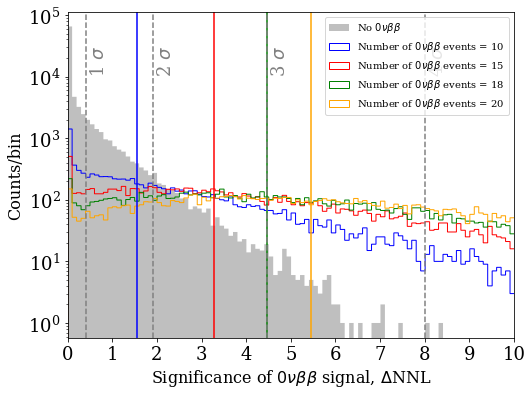

In [13]:
hist = {}
medians = {}
for Livetime in Livetimes:
    fig = plt.figure(figsize=(8,6))
    
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    FoundNull = np.char.find(list(DeltaNLL[Livetime].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Livetime].keys())[NullIndex]
    
    hist[NullSet] = plt.hist(np.abs(DeltaNLL[Livetime][NullSet]), 
                                                         bins=np.linspace(0,100,1000), 
                                                         label=r'No $0\nu\beta\beta$', 
                                                         histtype='stepfilled', 
                                                         color='grey', 
                                                         alpha=0.5)

    medians[Livetime] = []
    for ii,key in enumerate(list(DeltaNLL[Livetime].keys())[1:]):
        print(ii,key)
        hist[key] = plt.hist(np.abs(DeltaNLL[Livetime][key]), 
                             bins=np.linspace(0,100,1000), 
                             label=r'Number of $0\nu\beta\beta$ events = %s' % label[ii], 
                             histtype='step', 
                             color=colors[ii])
        plt.axvline(x=np.median(np.abs(DeltaNLL[Livetime][key])), ymin=0, ymax=1000, ls='-', color=colors[ii])
        medians[Livetime].append(np.median(np.abs(DeltaNLL[Livetime][key])))

    xmax = 10
    plt.xlim(0,xmax)
    plt.xticks(np.arange(0,xmax+0.1,xmax/10.0))
    plt.yscale('log')
    plt.xlabel(r'Significance of $0\nu\beta\beta$ signal, $\Delta$NNL', fontsize=16)
    plt.ylabel('Counts/bin', fontsize=16)
    plt.legend(loc='upper right', fontsize=10)

    for ii in [1,2,3]:  
        index = int(st.norm.cdf(ii)*len(np.abs(DeltaNLL[Livetime][NullSet])))
        xpos = sorted(np.abs(DeltaNLL[Livetime][NullSet]))[index]
        plt.axvline(x=xpos, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(xpos+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (ii),rotation=90, color='grey')

    # Significance assuming Wilks' theorem for sigma > 3
    # see slide 11 in https://indico.cern.ch/event/162087/contributions/235303/attachments/189340/265790/cowan_cargese_2.pdf
    for sigma in [4]:
        plt.axvline(x=sigma**2/2.0, ymin=0, ymax=1000, ls='--', color='grey')
        plt.text(sigma**2/2.0+0.1, np.max(hist[NullSet][0])*0.3,r'%d $\sigma$' % (sigma),rotation=90, color='grey')


    plt.savefig('null_hypothesis_%dyrs.pdf' % Livetime, bbox_inches='tight')

In [14]:
sigma = {}
Cut = {}
XInterp = {}
Interpolation = {}

for Livetime in Livetimes:
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    FoundNull = np.char.find(list(DeltaNLL[Livetime].keys()), '_0ct_')
    NullIndex = np.where(FoundNull > 0)[0][0]
    NullSet = list(DeltaNLL[Livetime].keys())[NullIndex]
    
    sorted_nll = sorted(DeltaNLL[Livetime][NullSet])
    sigma[Livetime] = []
    for ii,key in enumerate(list(DeltaNLL[Livetime].keys())[1:]):
        diff_abs = np.abs(sorted_nll - medians[Livetime][ii])
        nll_val = np.min(diff_abs)
        cut = np.where(diff_abs == nll_val)[0][0]
        print(label[ii], nll_val, cut, cut/len(sorted_nll), st.norm.ppf(cut/len(sorted_nll)), np.sqrt(2*medians[Livetime][ii]))

        sigma[Livetime].append(st.norm.ppf(cut/len(sorted_nll)))
    
    
    XInterp[Livetime] = np.linspace(int(label[0]),int(label[-1]),1000)
    Interpolation[Livetime] = np.interp(XInterp[Livetime], np.array(label).astype(int), sigma[Livetime])
    Diff = np.abs(Interpolation[Livetime] - 3.0)
    Cut[Livetime] = np.where(Diff == np.min(Diff))[0][0]
    print(XInterp[Livetime][Cut[Livetime]], GetLivetime(XInterp[Livetime][Cut[Livetime]], Livetime))

10 0.00013192568221365164 86766 0.9653323246033688 1.8162283510669108 1.7683034949579108
15 0.0004947885517685435 89451 0.9952048241027125 2.590259820842536 2.56314541463916
18 0.0004635635879157718 89762 0.9986649162234931 3.0033595604264156 2.9913228999812382
20 0.0031262020472375696 89845 0.9995883491689104 3.344839609654429 3.3031280899764135
17.97797797797798 4.86528397746059e+27


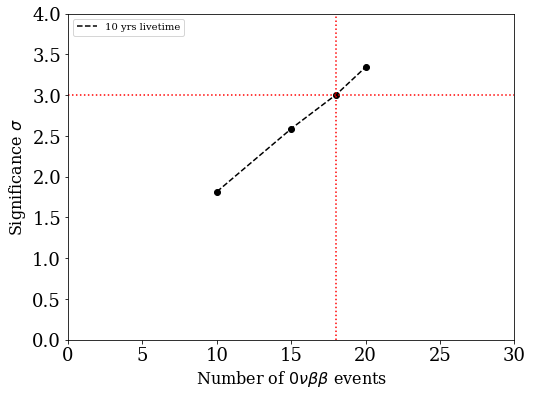

In [15]:
for Livetime in Livetimes:
    label = [x[len('DiscoveryPotential_bb0n_'):x.find('ct_')] for x in list(DeltaNLL[Livetime].keys())][1:] # get number of counts from tag name
    
    fig = plt.figure(figsize=(8,6))
    plt.plot(XInterp[Livetime], Interpolation[Livetime], label='%d yrs livetime' % Livetime, ls='--', color='k')
    plt.scatter(np.array(label).astype(int), sigma[Livetime], color='k')
    plt.axhline(3, color='r', ls=':')
    plt.axvline(XInterp[Livetime][Cut[Livetime]], color='r', ls=':')

    plt.xlim(0,30)
    plt.ylim(0,4)
    plt.xlabel(r'Number of $0\nu\beta\beta$ events', fontsize=16)
    plt.ylabel(r'Significance $\sigma$ ', fontsize=16)
    plt.legend(loc='upper left', fontsize=10)
    plt.savefig('sigma_vs_bb0n_%dyrs.pdf' % Livetime, bbox_inches='tight')